# Kalbe Nutritionals - Machine Learning Project

In this project, I'm given the role as a data scientist in Kalbe Nutritionals. I am provided with 4 files from sales database to use for this project. The tasks for this project are as follow:
1. **Product quantity prediction**: Inventory department requested for total sales prediction for all products to make sure they have enough stock available daily
2. **Customer Segmentation**: Marketing department requested for clustering model to help make customer segmentations for personalized promotion and sales treatment in the future 

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error 
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, InterpolationWarning

pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format

custom_rc = {'figure.figsize': (12,8),
             'axes.labelsize': 14,
             'figure.titlesize': 18}
rcParams.update(custom_rc)

In [2]:
import warnings
warnings.simplefilter(action='ignore', 
                      category=(InterpolationWarning, FutureWarning, ValueWarning, ConvergenceWarning, UserWarning))

plt.style.use('ggplot')

## Dataset Collection & Preparation

In [3]:
df_cust = pd.read_csv('Case Study - Customer.csv', delimiter=';')
df_prod = pd.read_csv('Case Study - Product.csv', delimiter=';')
df_stor = pd.read_csv('Case Study - Store.csv', delimiter=';')
df_trnx = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

In [4]:
# Function to check if there is duplicates in column
def check_duplicate(df, col):
    '''
    df: Dataframe to check for duplicated columns
    col: Column or list of columns to check for duplicates

    Print result whether duplicates are found or not
    '''
    try:
        has_dupe = df[col].duplicated().any()
        if has_dupe:
            dupes = df[col].duplicated().sum()
            print(f'There are {dupes} duplicates found in {col}')
        else:
            print(f'There is no duplicate found in {col}')

    except Exception as e:
        print('Something is wrong in the parameter input')

### Customer Data Validation

In [5]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


Columns' descriptions provided by data engineer:
- **CustomerID**    : Unique customer's id number
- **Age**           : Customer's age
- **Gender**        : Customer's gender (0: Female, 1: Male)
- **Marital Status**: Customer's marital status (Married, Single)
- **Income**        : Customer's monthly income in millions rupiah

In [6]:
check_duplicate(df_cust, 'CustomerID')

There is no duplicate found in CustomerID


In [7]:
df_cust.head(3)

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"


In [8]:
# Drop missing values since it only consists of <1% of the customer data
df_cust.dropna(inplace=True)

# Clean up income's value and datatype
df_cust['Income'] = df_cust['Income'].apply(lambda x: x.replace(',', '.'))
df_cust['Income'] = df_cust['Income'].astype('float')

# Change Gender column name to Male for interpretability
df_cust.rename(columns={'Gender': "Male"}, inplace=True)

df_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      444 non-null    int64  
 1   Age             444 non-null    int64  
 2   Male            444 non-null    int64  
 3   Marital Status  444 non-null    object 
 4   Income          444 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 20.8+ KB


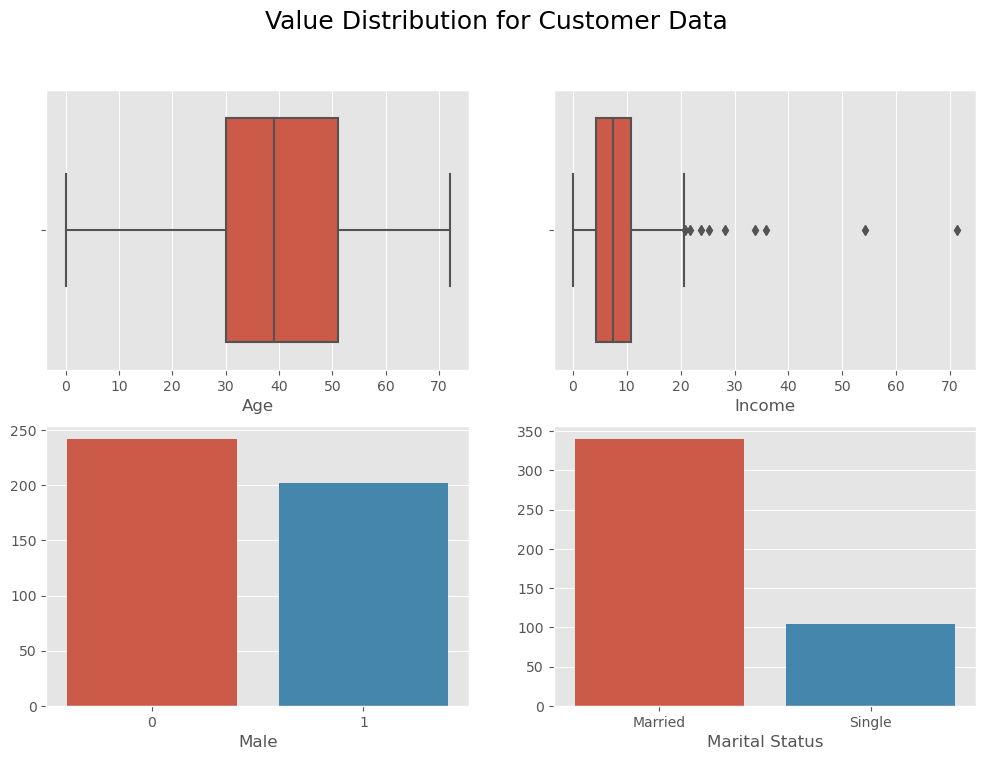

In [9]:
plt.suptitle('Value Distribution for Customer Data')
for i, col in enumerate(['Age', 'Income']):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df_cust[col])

for i, col in enumerate(['Male', 'Marital Status']):
    plt.subplot(2,2,i+3)
    sns.countplot(x=df_cust[col])
    plt.ylabel('')

While there seems to be some outliers in **Income**, those numbers are still plausible. Thus, in this case they will be treated as valid outliers.

### Product Data Validation

In [10]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


Columns' descriptions provided by data engineer:
- **ProductID**  : Unique product's id number
- **ProductName**: Product's name
- **Price**      : Product's price in rupiah

In [11]:
check_duplicate(df_prod, 'ProductID')

There is no duplicate found in ProductID


In [12]:
df_prod.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


Product data is already clean

### Store Data Validation

In [13]:
df_stor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


Columns' descriptions provided by data engineer:
- **StoreID**   : Unique store's id code
- **StoreName** : Store's name
- **GroupStore**: Store's group name
- **Type**      : Store's type (Modern Trade, General Trade)
- **Latitude**  : Store's latitude coordinate
- **Longitude** : Store's longitude coordinate

In [14]:
check_duplicate(df_stor, 'StoreID')

There is no duplicate found in StoreID


In [15]:
df_stor.head(3)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"


In [16]:
# Clean up latitude and longitude value and data type
df_stor['Latitude'] = df_stor['Latitude'].apply(lambda x: x.replace(',', '.'))
df_stor['Latitude'] = df_stor['Latitude'].astype('float')

df_stor['Longitude'] = df_stor['Longitude'].apply(lambda x: x.replace(',', '.'))
df_stor['Longitude'] = df_stor['Longitude'].astype('float')

df_stor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes


### Transaction Data Validation

In [17]:
df_trnx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


Columns' descriptions provided by data engineer:
- **TransactionID**: Unique transactions's id code
- **CustomerID**   : Customer's id number in transaction
- **Date**         : Transaction's date
- **ProductID**    : Product's id number in transaction
- **Price**        : Product's price
- **Qty**          : Total quantity of product in the transaction
- **TotalAmount**  : Total amount spent in transaction (**Qty** x **Price**)
- **StoreID**      : Store's id code in transaction

In [18]:
df_trnx.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,5020.0000,221.2637,129.6730,1.0000,108.0000,221.0000,332.0000,447.0000
Price,5020.0000,9684.8008,4600.7088,3200.0000,4200.0000,9400.0000,15000.0000,18000.0000
Qty,5020.0000,3.6446,1.8553,1.0000,2.0000,3.0000,5.0000,10.0000
TotalAmount,5020.0000,32279.4821,19675.4625,7500.0000,16000.0000,28200.0000,47000.0000,88000.0000
StoreID,5020.0000,7.4898,4.0285,1.0000,4.0000,7.0000,11.0000,14.0000


In [19]:
df_trnx.describe(include='object').T

,count,unique,top,freq
TransactionID,5020,4908,TR71313,3
Date,5020,365,02/03/2022,31
ProductID,5020,10,P5,814


In [20]:
check_duplicate(df_trnx, 'TransactionID')

There are 112 duplicates found in TransactionID


In [21]:
df_trnx[df_trnx.TransactionID.duplicated(keep=False)].sort_values(by='TransactionID').head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1655,TR11542,374,29/04/2022,P10,15000,4,60000,4
3022,TR11542,286,07/08/2022,P8,16000,1,16000,8
574,TR12602,338,11/02/2022,P2,3200,7,22400,2
2079,TR12602,154,30/05/2022,P7,9400,6,56400,13
3575,TR1280,60,17/09/2022,P10,15000,5,75000,2


It appears that there are duplicated **TransactionID** despite being completely unique judging by other columns. Some workaround involves combining **TransactionID** with **CustomerID** to create unique id. However, for the scope of this project, that might not be necessary so I will leave them as is.

In [22]:
df_trnx['Date'] = pd.to_datetime(df_trnx['Date'], format='%d/%m/%Y')
df_trnx.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


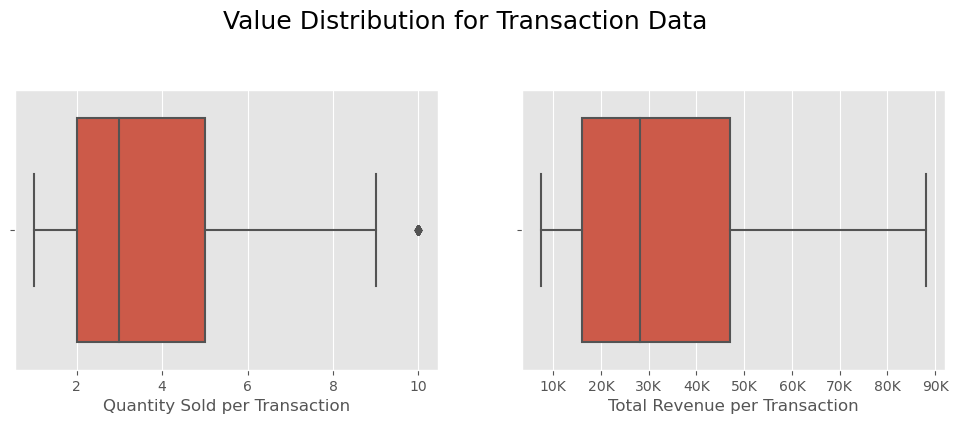

In [23]:
plt.suptitle('Value Distribution for Transaction Data')

# Quantity
plt.subplot(2,2,1)
sns.boxplot(x=df_trnx['Qty'])
plt.xlabel('Quantity Sold per Transaction')

# Revenue (price x qty)
plt.subplot(2,2,2)
g = sns.boxplot(x=df_trnx['TotalAmount'])
plt.xlabel('Total Revenue per Transaction')
xticks = [f'{x:.0f}K' for x in g.get_xticks()/1000]
plt.xticks(g.get_xticks()[1:-1], xticks[1:-1])
plt.show()

## Data Merge

In [24]:
# Inner join to remove missing values dropped from previous steps
df = pd.merge(df_trnx, df_cust, 
              how='inner', on='CustomerID')
df = pd.merge(df, df_prod.drop('Price', axis=1),
              how='inner', on='ProductID')
df = pd.merge(df, df_stor,
              how='inner', on='StoreID')

# Rearrange columns
df = df[['TransactionID', 'CustomerID', 'Date',
        'Age', 'Male', 'Marital Status', 'Income',
        'ProductID', 'Product Name', 'Price', 'Qty', 'TotalAmount', 
        'StoreID', 'StoreName', 'GroupStore', 'Type', 'Latitude', 'Longitude']]
df.head()

,TransactionID,CustomerID,Date,Age,Male,Marital Status,Income,ProductID,Product Name,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,36,0,Married,10.5300,P3,Crackers,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.9909,104.7566
1,TR89318,183,2022-07-17,27,1,Single,0.1800,P3,Crackers,7500,1,7500,12,Prestasi Utama,Prestasi,General Trade,-2.9909,104.7566
2,TR9106,123,2022-09-26,34,0,Married,4.3600,P3,Crackers,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.9909,104.7566
3,TR4331,335,2022-01-08,29,1,Single,4.7400,P3,Crackers,7500,3,22500,12,Prestasi Utama,Prestasi,General Trade,-2.9909,104.7566
4,TR6445,181,2022-01-10,33,1,Married,9.9400,P3,Crackers,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.9909,104.7566


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4976 entries, 0 to 4975
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   4976 non-null   object        
 1   CustomerID      4976 non-null   int64         
 2   Date            4976 non-null   datetime64[ns]
 3   Age             4976 non-null   int64         
 4   Male            4976 non-null   int64         
 5   Marital Status  4976 non-null   object        
 6   Income          4976 non-null   float64       
 7   ProductID       4976 non-null   object        
 8   Product Name    4976 non-null   object        
 9   Price           4976 non-null   int64         
 10  Qty             4976 non-null   int64         
 11  TotalAmount     4976 non-null   int64         
 12  StoreID         4976 non-null   int64         
 13  StoreName       4976 non-null   object        
 14  GroupStore      4976 non-null   object        
 15  Type

## Time Series Regression for Product Quantity Prediction

As specified by inventory department's requirement, I am tasked to predict the product quantity available in stock based on available data. Before machine learning prediction can be done, it is necessary to preprocess the data to fit into a time series regression.

In [27]:
# Daily sales data for year 2022
df_qty = df.groupby('Date').agg({'Qty': 'sum'})
df_qty.head()

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,28


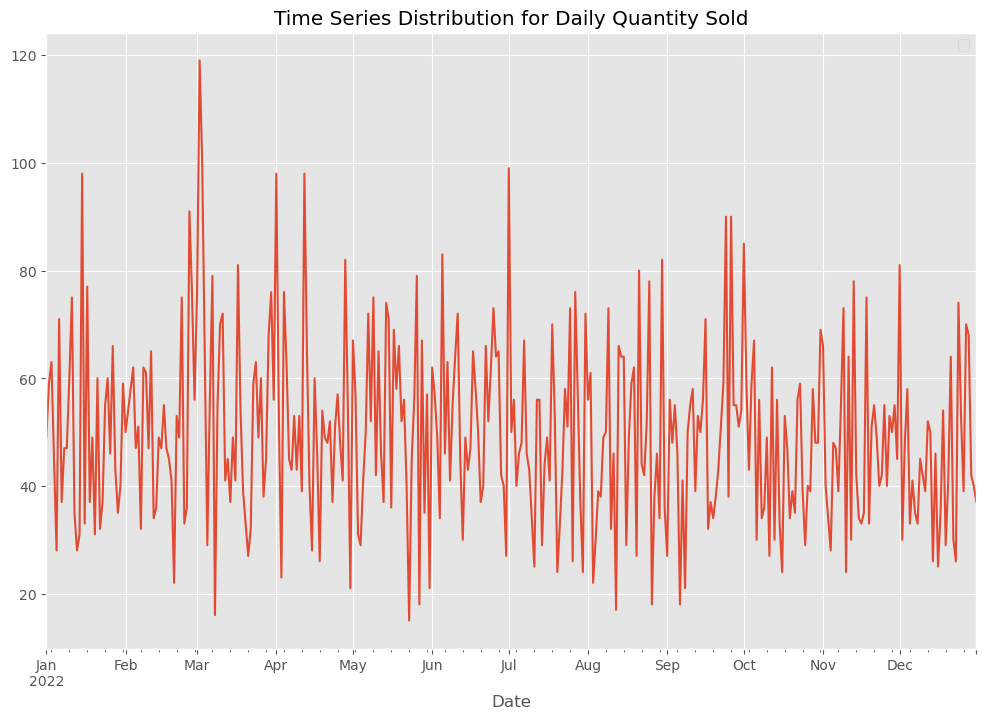

In [28]:
df_qty.plot()
plt.title('Time Series Distribution for Daily Quantity Sold')
plt.legend('')
plt.show()

Based on the graph above, time series data for daily quantity sold seems to be stationary.

However, to make sure of data staionarity, some ADFuller and KPSS test will be done for the data.

### Stationarity Check

In [29]:
def adf_stationarity(data, critical_value=0.05):
    adf = adfuller(data)

    if adf[1] < critical_value:
        print('ADFuller result: stationary')
    else:
        print('ADFuller result: not stationary')

def kpss_stationarity(data, critical_value=0.05):
    kpss_ = kpss(data)
    
    if kpss_[1] < critical_value:
        print('KPSS     result: not stationary')
    else:
        print('KPSS     result: stationary')

In [30]:
adf_stationarity(df_qty)
kpss_stationarity(df_qty)

ADFuller result: stationary
KPSS     result: not stationary


Based on the result above, this data is [difference stationary](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#:~:text=Case%204%3A%20KPSS%20indicates%20non%2Dstationarity%20and%20ADF%20indicates%20stationarity%20%2D%20The%20series%20is%20difference%20stationary.%20Differencing%20is%20to%20be%20used%20to%20make%20series%20stationary.%20The%20differenced%20series%20is%20checked%20for%20stationarity.). 

In [31]:
adf_stationarity(df_qty.diff().dropna())
kpss_stationarity(df_qty.diff().dropna())

ADFuller result: stationary
KPSS     result: stationary


Time series is stationary on both ADFuller and KPSS test on first difference.

### PACF and ACF Analysis

PACF and ACF will be used to estimate the optimal term for *p* and *q* for ARIMA model. On top of that, they will serve as an additional measure to test for optimal order of difference (*d* term)

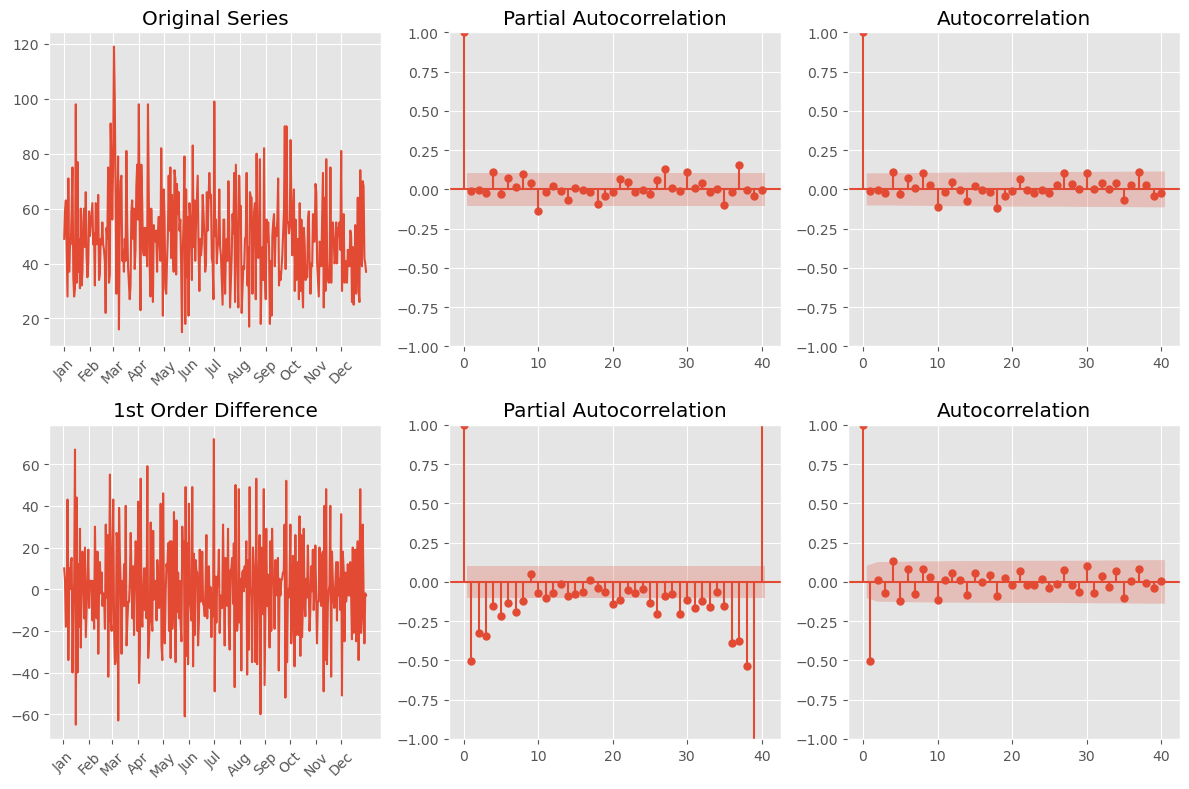

In [32]:
fig, axes = plt.subplots(2,3,)
month_start = df_qty.index[df_qty.index.is_month_start]

axes[0, 0].plot(df_qty.Qty)
axes[0, 0].set_title('Original Series')
axes[0, 0].set_xticks(month_start, [date.strftime('%b') for date in month_start], rotation=45)
plot_pacf(df_qty.Qty, ax=axes[0, 1], lags=40)
plot_acf(df_qty.Qty, ax=axes[0, 2], lags=40)

axes[1, 0].plot(df_qty.Qty.diff())
axes[1, 0].set_title('1st Order Difference')
axes[1, 0].set_xticks(month_start, [date.strftime('%b') for date in month_start], rotation=45)
plot_pacf(df_qty.Qty.diff().dropna(), ax=axes[1, 1], lags=40)
plot_acf(df_qty.Qty.diff().dropna(), ax=axes[1, 2], lags=40)

plt.tight_layout()

While the first order of differencing provides a more stationary time series, it's PACF plot shows an indication of [over differencing](https://www.linkedin.com/advice/1/how-do-you-deal-over-differencing-under-differencing#:~:text=If%20the%20ACF%20and%20PACF%20show%20significant%20spikes%20at%20high%20lags%2C%20or%20if%20the%20ACF%20decays%20very%20slowly%2C%20you%20may%20have%20over%2Ddifferenced%20your%20data.) that can be seen from a spike in PACF around 40 lags. Thus, I will be using 0 as *d* term for the ARIMA model.

For *p* and *q* term, they will be manually determined by looking for lags on PACF and ACF with y approaching 0 in the original time series. Based on that criteria, there are several numbers of lag such as:
- **p**: 2, 7, 12, 15, 24, 28, 31
- **q**: 2, 7, 13, 15, 22, 29, 31

For the scope of this project, I will choose 3 or 4 max from each to save time.

### Train Test Split

In [33]:
# train test split 80:20
cutoff = round(df_qty.shape[0] * 0.8)
qty_train = df_qty[:cutoff]
qty_test = df_qty[cutoff:]

### ARIMA Batch Modeling

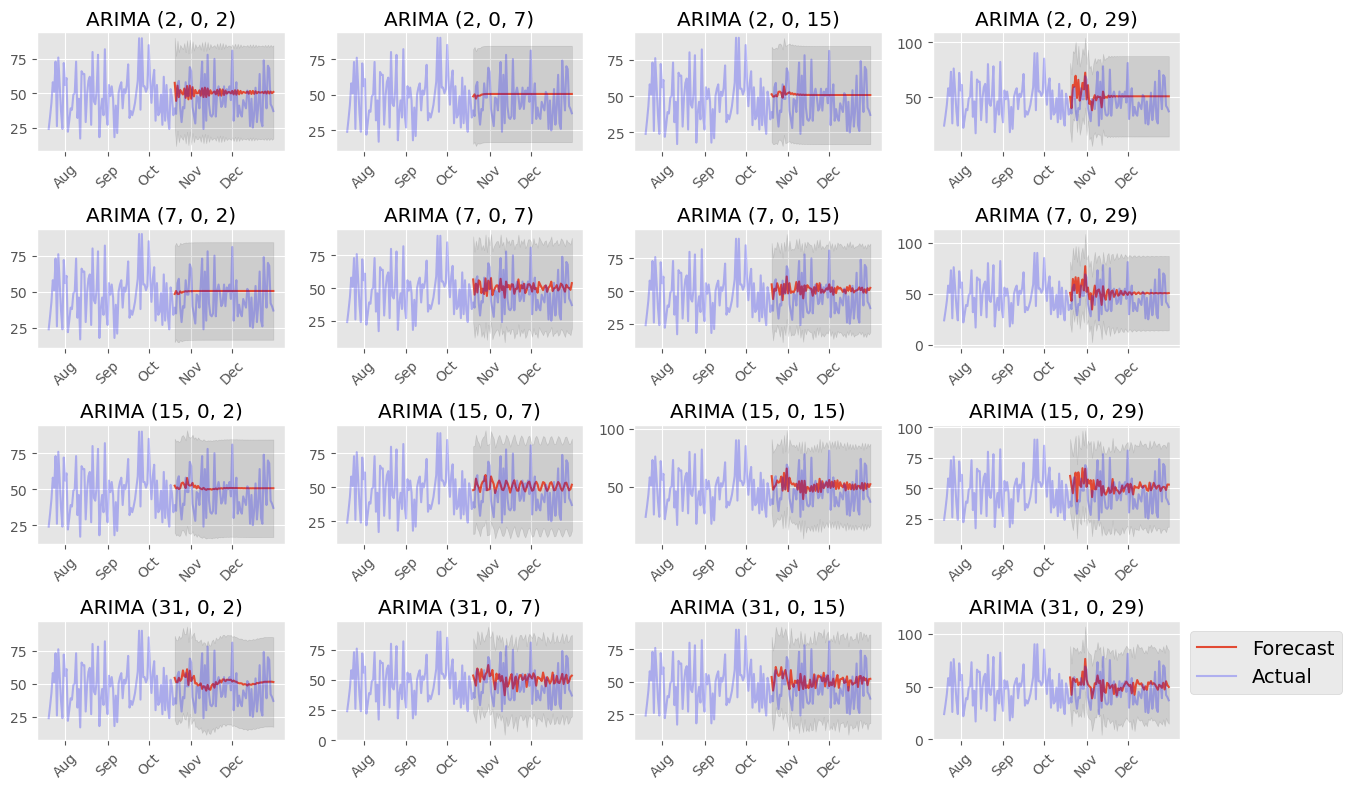

In [48]:
fig, axes = plt.subplots(4, 4)

p_terms = [2,7,15,31]
q_terms = [2,7,15,29]

eval_table = {'model': [],
              'mae': [],
              'mape': [],
              'rmse': []}

for i, p  in enumerate(p_terms):
    for j, q in enumerate(q_terms):
        # Run model
        model = ARIMA(qty_train, order=(p,0,q))
        model_fit = model.fit()
        model_name = f'ARIMA ({p}, 0, {q})'
        fc = model_fit.get_forecast(len(qty_test))
        pred = fc.predicted_mean

        # Evaluate model results
        mae = round(mean_absolute_error(qty_test, pred), 4)
        mape = round(mean_absolute_percentage_error(qty_test, pred), 4)
        rmse = round(mean_squared_error(qty_test, pred, squared=False), 4)
        eval_table['model'].append(model_name)
        eval_table['mae'].append(mae)
        eval_table['mape'].append(mape)
        eval_table['rmse'].append(rmse)

        # Plot forecast
        month_start = df_qty[200:].index[df_qty[200:].index.is_month_start]
        axes[i, j].plot(fc.predicted_mean, label='Forecast')
        axes[i, j].plot(df_qty[200:], label='Actual', alpha=.25, c='b')
        axes[i, j].fill_between(fc.conf_int().index,
                        fc.conf_int()['lower Qty'],
                        fc.conf_int()['upper Qty'],
                        color='k', alpha=.1)
        axes[i, j].set_xticks(month_start, 
                              [date.strftime('%b') for date in month_start], 
                              rotation=45)
        axes[i, j].set_title(model_name)
        
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1), fontsize=14, loc='upper left')
plt.show()

Based on the graph above, the graphs can be classified into:
1. General flatlining: where the model only manage to generalize guess without capturing pattern, examples are (2,0,7) and (7,0,2)
2. Fluctuating flatline: where the model learned enough pattern fluctuations, but failed to capture fluctuation in trends, examples are (7,0,7), (7,0,15), and (15,0,7)
3. General trend: where the model managed to fit into the general trend only, the only example is (31,0,2)
4. Partial good fit: where the model either managed to fit well at certain range into the predictions, examples are (2,0,29), (7,0,29), (15,0,29), (31,0,7), (31,0,15), and (31,0,29)

Unfortunately, there is no model that fits well enough to predict the drop near the beginning of December. However, for this project, I will take a closer look on the model with partial good fit.

In [50]:
# Top 10 ARIMA model based on MAPE
eval_df = pd.DataFrame(eval_table)
eval_df.sort_values(by='mae').head(10)

,model,mae,mape,rmse
15,"ARIMA (31, 0, 29)",12.1816,0.3138,14.6144
4,"ARIMA (7, 0, 2)",12.2821,0.3115,14.5067
1,"ARIMA (2, 0, 7)",12.2859,0.3116,14.5029
0,"ARIMA (2, 0, 2)",12.3651,0.3137,14.4638
3,"ARIMA (2, 0, 29)",12.3898,0.3142,14.7786
12,"ARIMA (31, 0, 2)",12.4626,0.3169,14.8513
9,"ARIMA (15, 0, 7)",12.4695,0.3175,14.7495
5,"ARIMA (7, 0, 7)",12.4916,0.3167,14.4457
10,"ARIMA (15, 0, 15)",12.5634,0.3187,14.7058
2,"ARIMA (2, 0, 15)",12.5683,0.3201,14.7394


Based on evaluation table above, all models have very close error to each other despite having very much different visualization. Thus, error metrics will be used as additional criteria for model selection for this case.

### ARIMA with Partial Good Fit

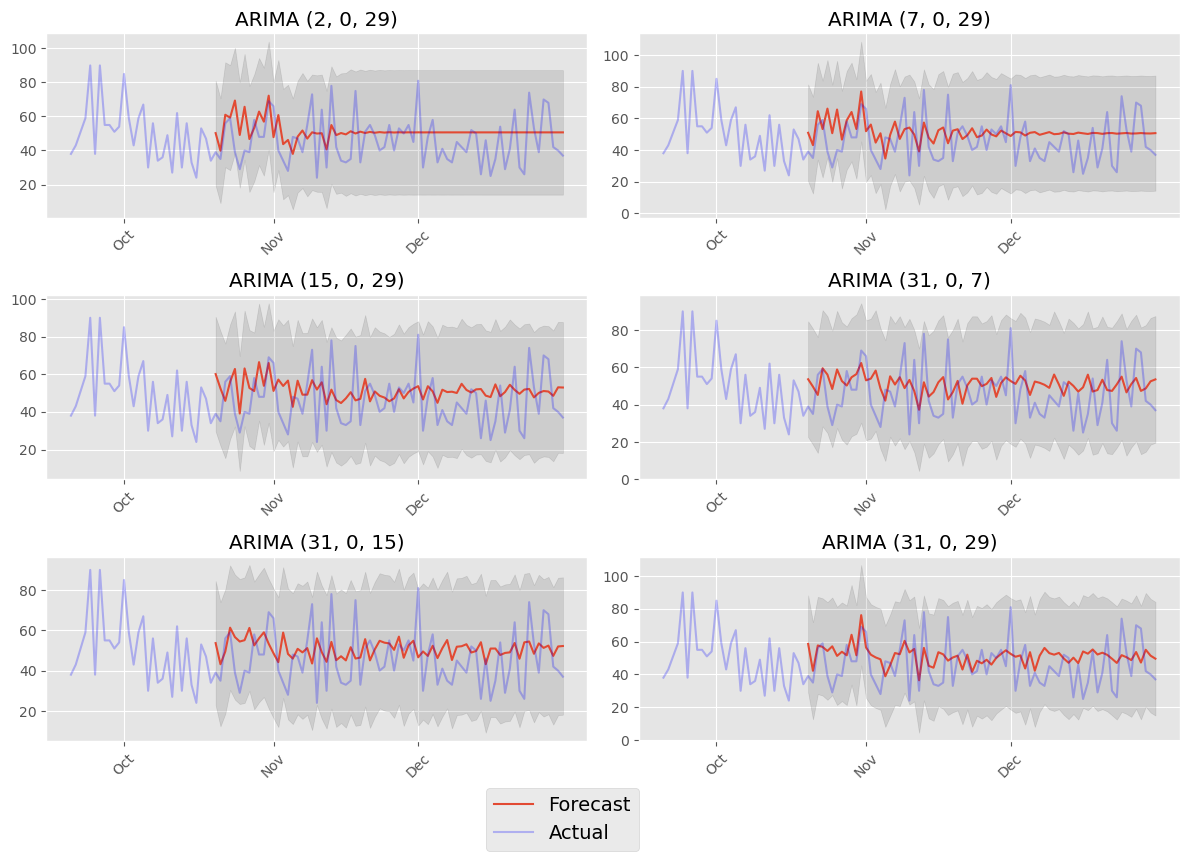

In [53]:
fig, axes = plt.subplots(3,2)
selected_orders = [( 2, 0, 29), ( 7, 0, 29),
                   (15, 0, 29), (31, 0,  7), 
                   (31, 0, 15), (31, 0, 29)]

eval_table = {'model': [],
              'mae': [],
              'mape': [],
              'rmse': []}

for i, order  in enumerate(selected_orders):
    # Run model
    model = ARIMA(qty_train, order=order)
    model_fit = model.fit()
    model_name = f'ARIMA {order}'
    fc = model_fit.get_forecast(len(qty_test))
    pred = fc.predicted_mean

    # Evaluate model results
    mae = round(mean_absolute_error(qty_test, pred), 4)
    mape = round(mean_absolute_percentage_error(qty_test, pred), 4)
    rmse = round(mean_squared_error(qty_test, pred, squared=False), 4)
    eval_table['model'].append(model_name)
    eval_table['mae'].append(mae)
    eval_table['mape'].append(mape)
    eval_table['rmse'].append(rmse)

    # Plot forecast
    month_start = df_qty[cutoff-30:].index[df_qty[cutoff-30:].index.is_month_start]
    ax = axes[i//2, i%2]
    ax.plot(fc.predicted_mean, label='Forecast')
    ax.plot(df_qty[cutoff-30:], label='Actual', alpha=.25, c='b')
    ax.fill_between(fc.conf_int().index,
                    fc.conf_int()['lower Qty'],
                    fc.conf_int()['upper Qty'],
                    color='k', alpha=.1)
    ax.set_xticks(month_start, 
                            [date.strftime('%b') for date in month_start], 
                            rotation=45)
    ax.set_title(model_name)
    
plt.tight_layout()
plt.legend(bbox_to_anchor=(-0.3,-0.2), fontsize=14, loc='upper left')
plt.show()

In general, most of them can grasp the first 2 weeks to 1 month prediction quite well. Based on the criteria, notable good fit for the first month prediction are:
1. (7,0,29)
2. (15,0,29): notably the only model that can predict the trough near the beginning of prediction
3. (31,0,29)

On the other hand, if the criteria is the whole test data or over 2 months prediction (31,0,29) might be the best overall.

### Selected Model: ARIMA (31,0,29)

In [50]:
arima = ARIMA(df_qty, order=(31,0,29))
model_fit = arima.fit()
# model_fit.summary()

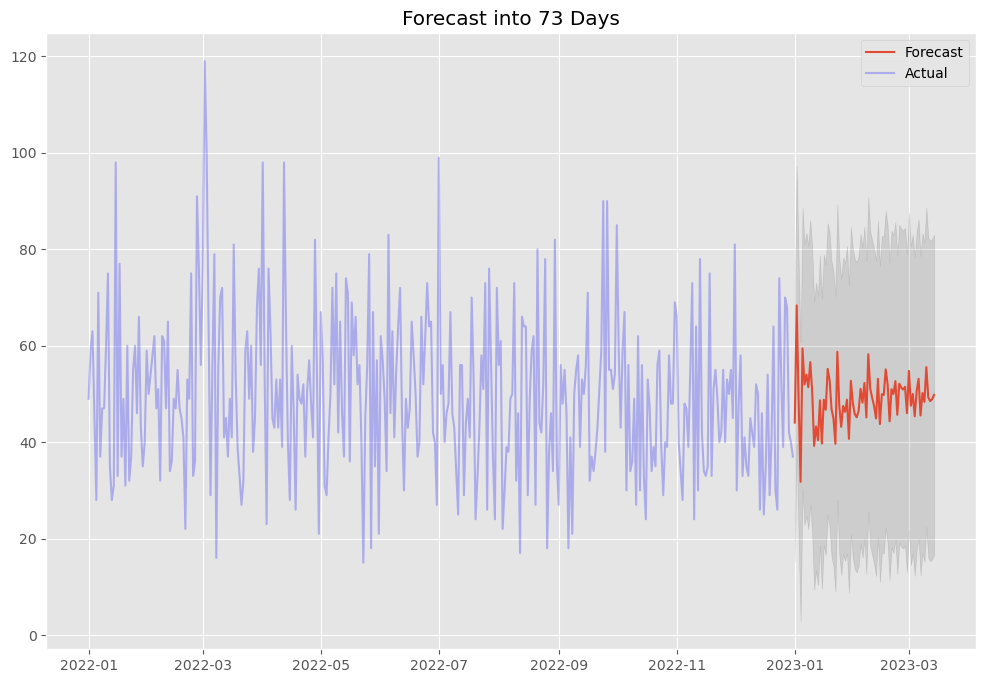

In [51]:
fc = model_fit.get_forecast(steps=len(qty_test))

plt.plot(fc.predicted_mean, label='Forecast')
plt.plot(df_qty, label='Actual', alpha=.25, c='b')
plt.fill_between(fc.conf_int().index,
                 fc.conf_int()['lower Qty'],
                 fc.conf_int()['upper Qty'],
                 color='k', alpha=.1)

plt.title(f'Forecast into {len(qty_test)} Days')
plt.legend(loc=1)
plt.show()

As expected from previous evaluation, the prediction starts of promising but starts to converge for further prediction into the future. For that reason, this model might be used for predicting shorter duration like 1 month or less.

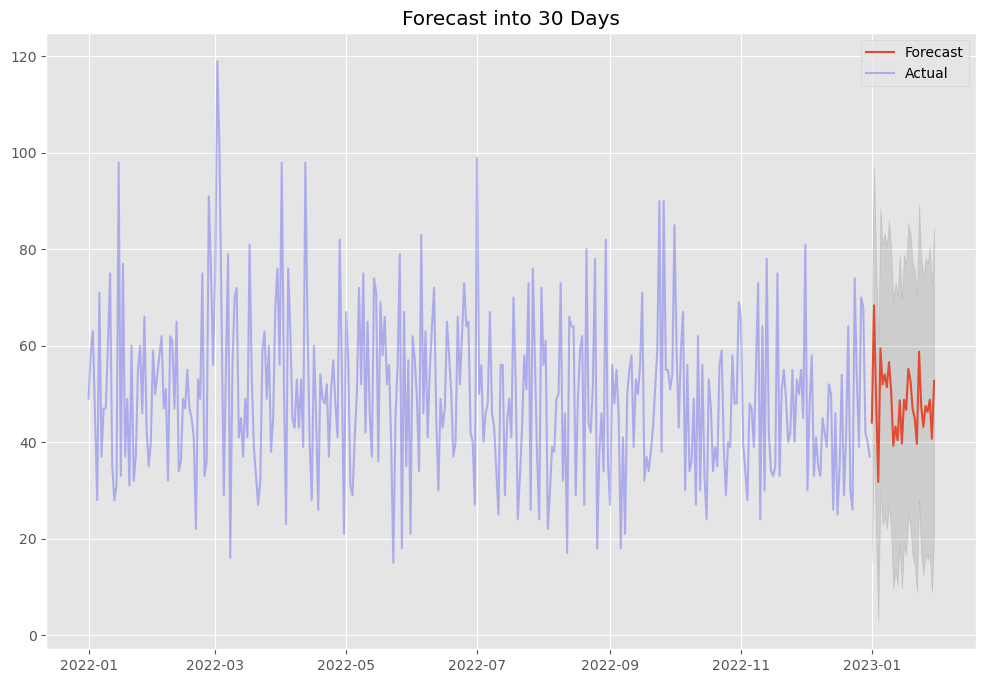

In [52]:
fc = model_fit.get_forecast(steps=30)

plt.plot(fc.predicted_mean, label='Forecast')
plt.plot(df_qty, label='Actual', alpha=.25, c='b')
plt.fill_between(fc.conf_int().index,
                 fc.conf_int()['lower Qty'],
                 fc.conf_int()['upper Qty'],
                 color='k', alpha=.1)

plt.title('Forecast into 30 Days')
plt.legend(loc=1)
plt.show()

In [57]:
avg_qty = np.mean(fc.predicted_mean)
print(f'Average daily quantity sold for the next 30 days: {avg_qty:.0f} pcs')

Average daily quantity sold for the next 30 days: 48 pcs


Based on that result, Kalbe should prepare inventory of around 1440 products in the next 30 days. Since the scope of this project doesn't include prediction for different product, it's difficult to recommend on how many stocks to prepare for each products.

That being said, the recommendations to be considered are as follow:
- Prepare 144-150 stocks of each products and refresh said number of stocks every months
- Do further analysis for quantity sold rate of each products

## Customer Segmentation

As specified by marketing department's requirement, I am tasked to make customer segmentation for personalized promotion purposes. The minimum requirements given by marketing department are transaction frequency, total quantity purchased, and total amount spent. To complete RFM analysis component of 'recency', I will also include last purchase date of each customers.

In [25]:
# Customer's transaction
df_clust = df.groupby('CustomerID').agg({'TransactionID': 'count',
                                         'Qty': 'sum',
                                         'TotalAmount': 'sum',
                                         'Date': 'max'}).reset_index()
df_clust.columns = ['CustomerID', 'TotalTranx', 'TotalPurchased', 'TotalSpending', 'LastPurchaseDate']
df_clust['LastPurchase'] = pd.to_datetime('2023-01-01') - df_clust['LastPurchaseDate']
df_clust['LastPurchase'] = df_clust['LastPurchase'].apply(lambda x: x.days)
df_clust.drop('LastPurchaseDate', axis=1, inplace=True)
df_clust.set_index('CustomerID', inplace=True)
df_clust.head()

,TotalTranx,TotalPurchased,TotalSpending,LastPurchase
CustomerID,,,,
1,17,60,623300,26
2,13,57,392300,25
3,15,56,446200,10
4,10,46,302500,5
5,7,27,268600,28


### Feature Scaling

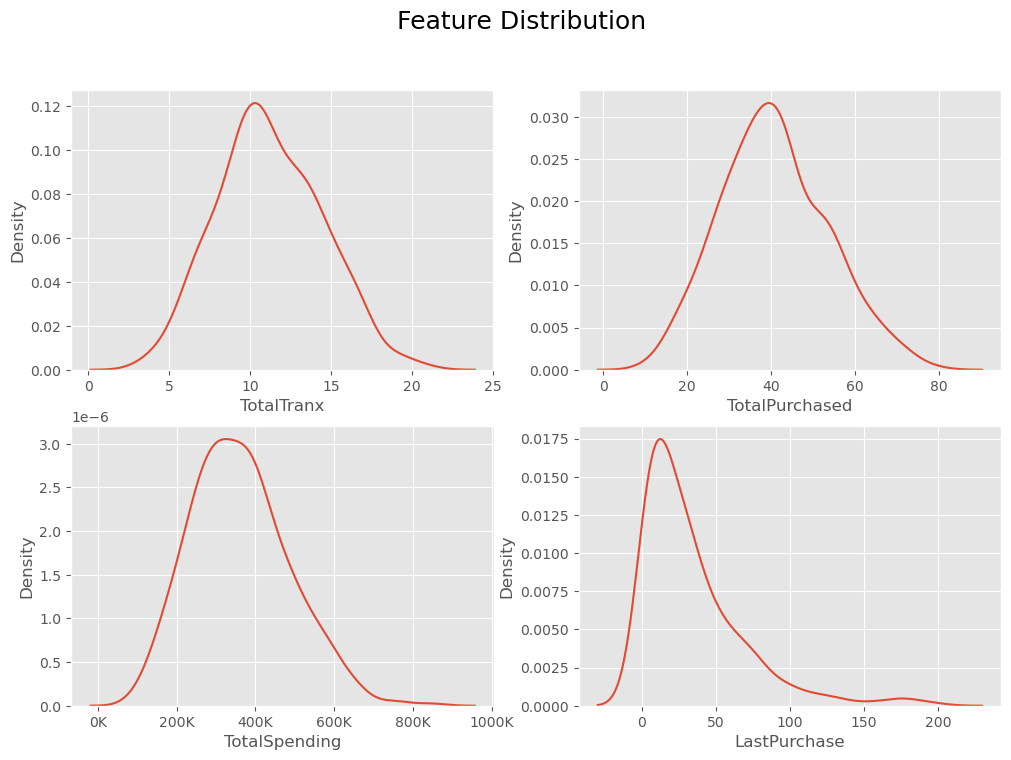

In [26]:
feats = df_clust.columns
plt.suptitle('Feature Distribution')
for i, feat in enumerate(feats):
    plt.subplot(2,2,i+1)
    g = sns.kdeplot(df_clust[feat])
    if feat == 'TotalSpending':
        xticks = [f'{x:.0f}K' for x in g.get_xticks()/1000]
        plt.xticks(g.get_xticks()[1:-1], xticks[1:-1])

There seems to be some outliers in **LastPurchase** columns. However since, it's important customer data for clustering, outliers will be included. Next will be to scale the features with [standard scaler](https://www.linkedin.com/advice/3/what-some-best-practices-preprocessing-scaling#:~:text=k%2Dmeans%20assumes%20that%20the%20clusters%20are%20spherical%20and%20have%20similar%20sizes%2C%20so%20it%20might%20benefit%20from%20standard%20scaling) to prepare for K-Means clustering.

In [27]:
scaler = StandardScaler()
scaler.fit(df_clust)

x = scaler.transform(df_clust)
df_unlabel = pd.DataFrame(x, columns=feats, index=df_clust.index)
df_unlabel.head()

,TotalTranx,TotalPurchased,TotalSpending,LastPurchase
CustomerID,,,,
1,1.7883,1.5089,2.1024,-0.2373
2,0.5534,1.2729,0.2463,-0.2660
3,1.1709,1.1942,0.6794,-0.6973
4,-0.3727,0.4074,-0.4752,-0.8410
5,-1.2988,-1.0875,-0.7476,-0.1798


### Determining Optimal Cluster

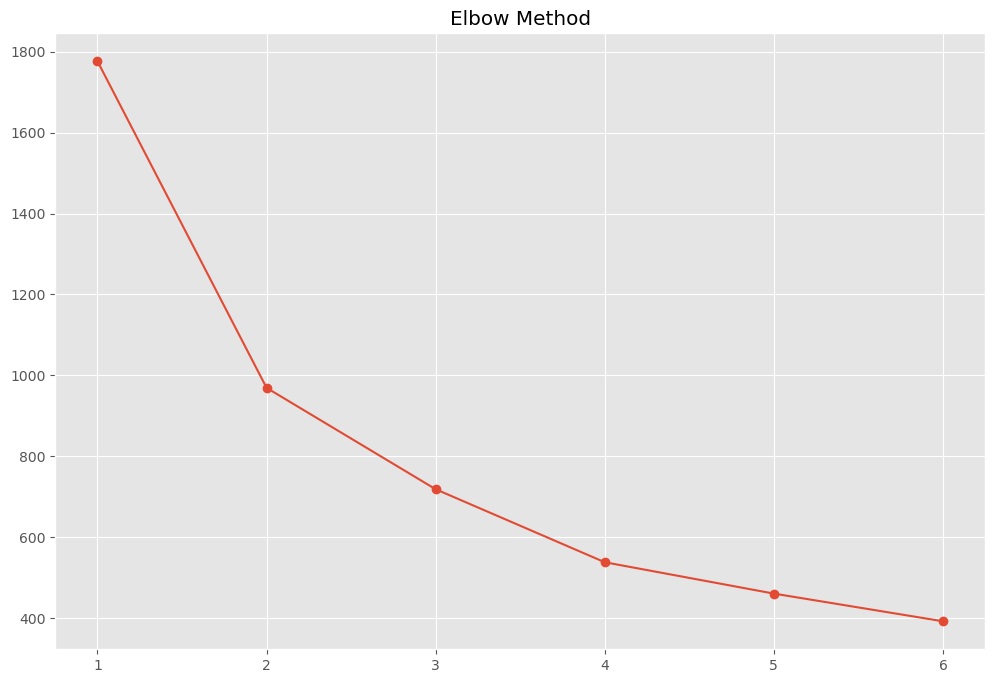

In [60]:
inertia = []

for i in range(1,7):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_unlabel)
    inertia.append(kmeans.inertia_)
    
plt.xticks(list(range(1,7)))
plt.plot(range(1,7),inertia,marker='o')
plt.title('Elbow Method')
plt.show()

In [61]:
eval_cluster = pd.DataFrame({'n_clusters': list(range(1,7)),
                             'inertia': inertia, 
                             'diff': pd.Series(inertia).diff(),
                             '% reduction vs before': pd.Series(inertia).diff() * -100 / inertia,
                             })
eval_cluster

,n_clusters,inertia,diff,% reduction vs before
0,1,1776.0000,NaN,NaN
1,2,969.4133,-806.5867,83.2036
2,3,719.0241,-250.3891,34.8235
3,4,538.7314,-180.2927,33.4662
4,5,461.2762,-77.4552,16.7915
5,6,392.9205,-68.3557,17.3968


Based on inertia and elbow method above, the optimal amount of cluster is at n_clusters between 3 or 4 where further reduction is not as significant.

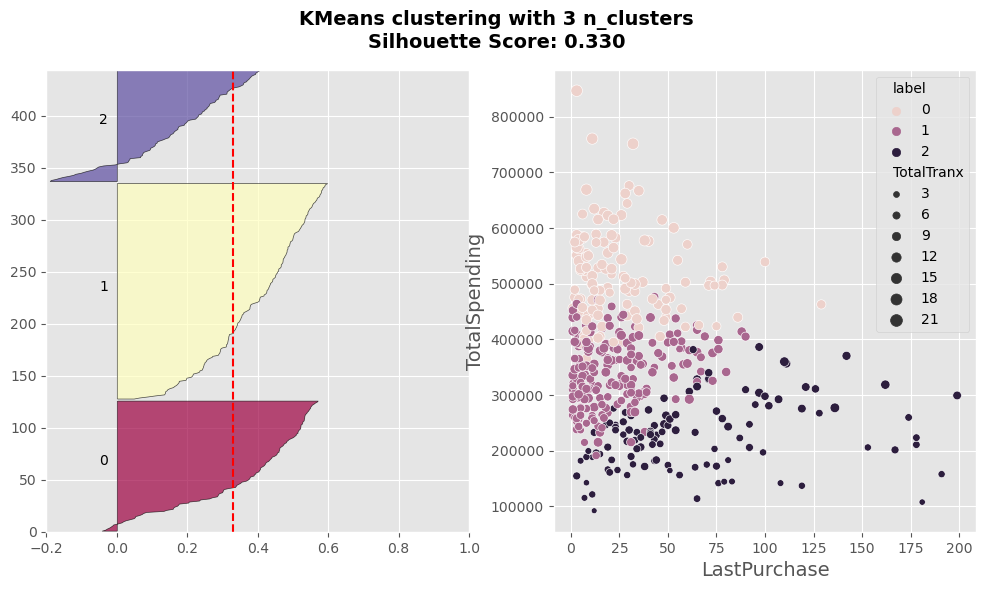

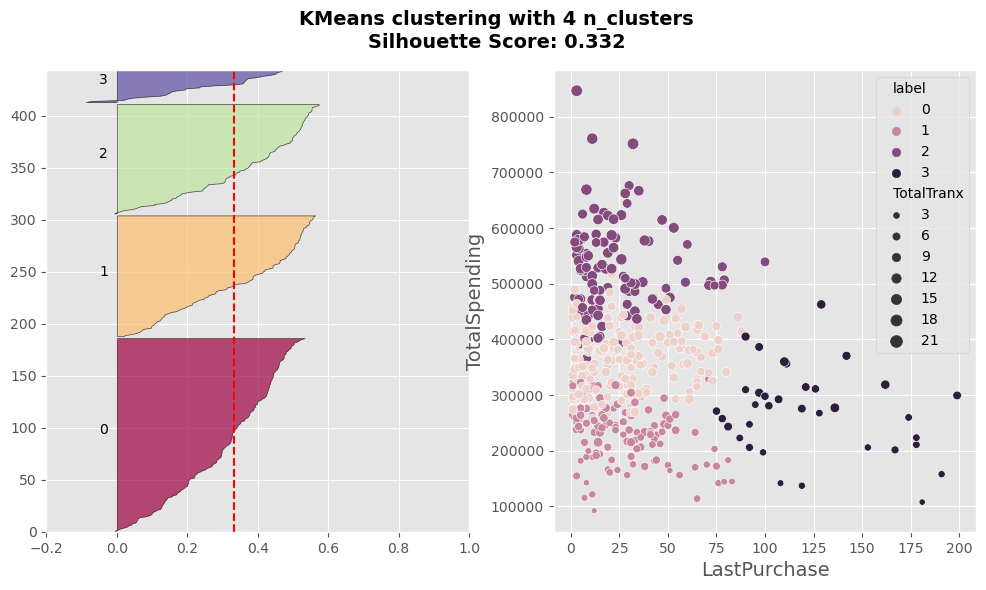

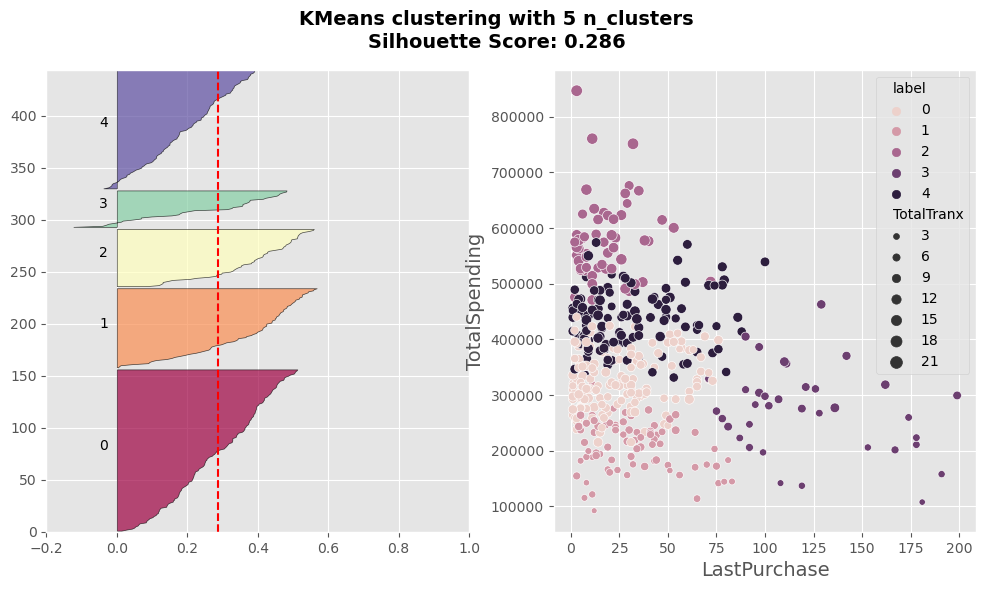

In [106]:
silh_score = {'n_cluster': [],
              'silhouette score': []}

df_clust_pred = df_clust.copy()

for n in range(3,6):
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    colors = plt.cm.Spectral(np.linspace(0, 1, n))
    
    # Run model
    model = KMeans(n_clusters=n, random_state=0)
    labels = model.fit_predict(df_unlabel)
    
    # Silhouette score: average and score per samples
    silhouette_avg = silhouette_score(df_unlabel, labels)
    silhouette_values = silhouette_samples(df_unlabel, labels)

    # Silhouette plot
    axes[0].set_xlim([-0.2, 1])
    axes[0].set_ylim([0, df_unlabel.shape[0] ])
    offset = 1
    y_lower = 1
    for i in range(n):
        sample_silh_values = silhouette_values[labels == i]
        sample_silh_values.sort()
        
        cluster_size = sample_silh_values.shape[0]
        y_upper = y_lower + cluster_size

        axes[0].fill_betweenx(np.arange(y_lower, y_upper),
                              0, sample_silh_values,
                              facecolor=colors[i], 
                              edgecolor='black', 
                              alpha=0.7)
        axes[0].text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        y_lower = y_upper + offset

    axes[0].axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # Plot cluster prediction
    df_clust_pred['label'] = labels
    axes[1] = sns.scatterplot(data=df_clust_pred,
                              x='LastPurchase', # Recency
                              size='TotalTranx', # Frequency
                              y='TotalSpending', # Monetary
                              hue='label')
                    
    plt.suptitle((f"KMeans clustering with {n} n_clusters\nSilhouette Score: {silhouette_avg:.3f}"),
                 fontsize=14, fontweight='bold')

plt.show()

Unfortunately, none of this model pass the 0.5 silhouette score threshold for high-quality cluster. However, this is good enough considering the data has several overlapping samples.

N clusters for optimal model is determined using the following steps:
1. N_clusters 5 is eliminated for having the lowest silhouette score
2. Comparing silhouette score between n_clusters 3 and 4, n_clusters 4 has slight edge with 0.332 score
3. N_clusters 3 is eliminated for having more negative sample scores, indicating wrong cluster classification
4. **N_clusters 4** is taken as the most optimal model

### K-Means Cluster Modeling

In [100]:
# Run optimal cluster model
kmeans = KMeans(n_clusters=4,
                init='k-means++',max_iter=300,n_init=10,random_state=0)
cluster_fit = kmeans.fit(df_unlabel)

# Put cluster label on pre-scaled df
df_label = df_clust.copy()
df_label['label'] = cluster_fit.labels_
df_label.reset_index(inplace=True)
df_label.head()

,CustomerID,TotalTranx,TotalPurchased,TotalSpending,LastPurchase,label
0,1,17,60,623300,26,2
1,2,13,57,392300,25,2
2,3,15,56,446200,10,2
3,4,10,46,302500,5,0
4,5,7,27,268600,28,1


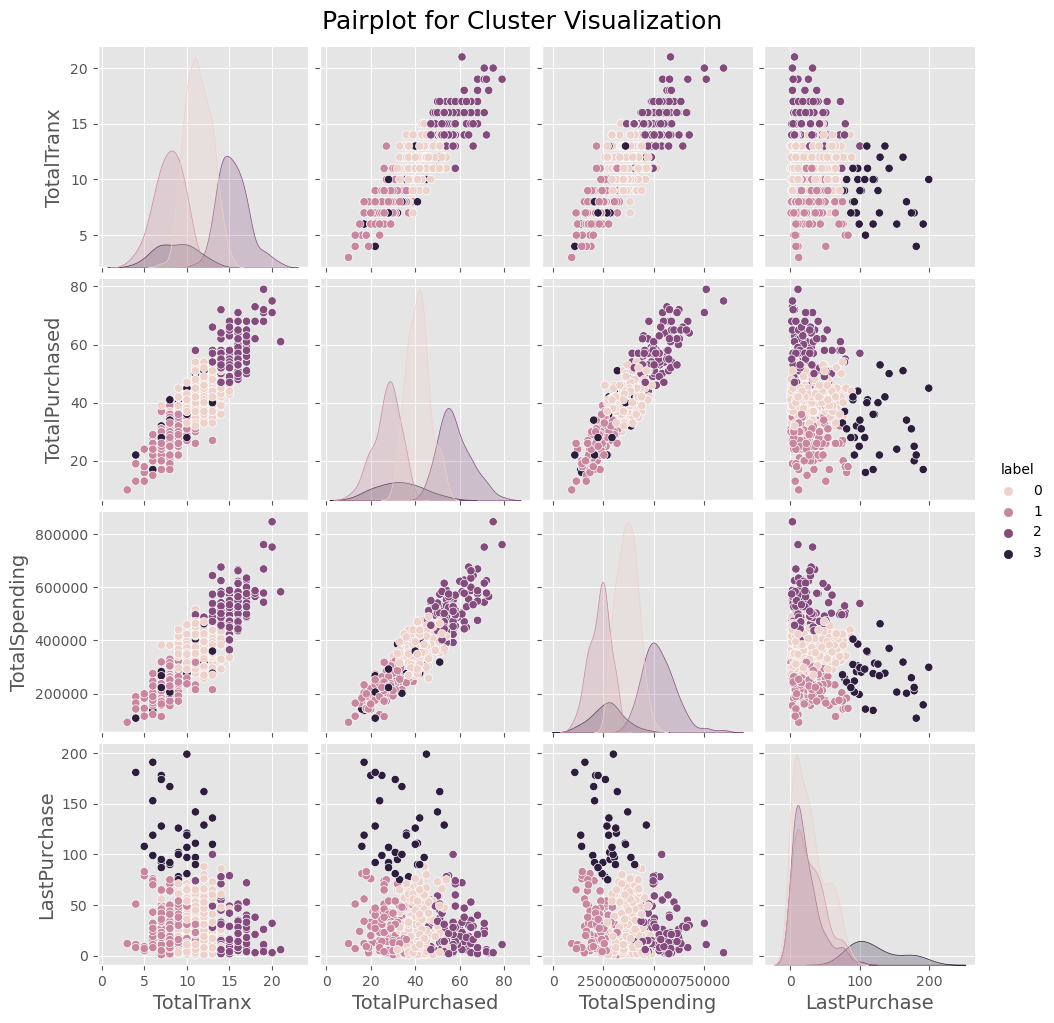

In [117]:
sns.pairplot(df_label.drop('CustomerID', axis=1), hue='label')
plt.suptitle('Pairplot for Cluster Visualization', y=1.02)
plt.show()

4 clusters can be clearly seen on pairplot with **LastPurchase** as one of the features. 

For better visualization, 3d graph might give better view for the clusters.

In [120]:
fig = px.scatter_3d(df_label,
                    x='LastPurchase', # Recency
                    y='TotalTranx', # Frequency
                    z='TotalSpending', # Monetary
                    color='label')
fig.show()

### Customer Segmentation based on [RFM](https://documentation.bloomreach.com/engagement/docs/rfm-segmentation#:~:text=than%20five%20minutes.-,RFM%20segments,-Based%20on%20the)

For simplifications, each criteria of RFM will be divided into 'Low', 'Medium', and 'High' as specified below:
- Recency is considered 'High', the **lower** LastPurchase is
- Frequency is considered 'High', the **higher** TotalTranx is
- Monetary is considered 'High', the **higher** TotalSpend is

1. Label 0 (**Potential Loyalists**):
    - Recency : High
    - Frequency : Medium
    - Monetary : Medium
    - Recommendation : **Offer personalized recommendations** to increase their range of product purchases. The more product variety they are engaged with, the more likely for them to have more purchases in the future.

2. Label 1 (**New Customers**):
    - Recency : High
    - Frequency : Low
    - Monetary : Low
    - Recommendation : **Offer get-one-free promotion** on their purchases. The additional free product can be the same or different product. The goal is to push more purchase while increasing the engagement towards all products.

3. Label 2 (**Champions**):
    - Recency : High
    - Frequency : High
    - Monetary : High
    - Recommendation : **Offer loyalty-program discounts** to encourage more bulk purchases from them. They are already loyal, so this will reduce the possibility of opportunistic buyers who's aiming for only discount purchase.

4. Label 3 (**Hibernating Customers**):
    - Recency : Low
    - Frequency : Low
    - Monetary : Low
    - Recommendation : **Offer high discounted promotions** for new products, whether new addition or product they never engaged with before. A possible cause customers might go hibernation is that they weren't satisfied with what they purchased before, so a different product might just be more interesting than their previous purchases.